In [1]:
import gym
import torch.nn as nn
import torch
import torch.nn.functional as F

env = gym.make('MountainCarContinuous-v0')

'https://medium.com/swlh/cartpole-with-policy-gradient-tensorflow-2-x-3a7a14b9cc03#:~:text=Policy%20gradient%20is%20a%20reinforcement,actions%20would%20be%20the%20best.'

### Model Architecture

- 3 Linear layers
- ReLU Activation function
- Softmax Ouptut function

Learning rate: 1e-3  
Gamma: 0.95

In [2]:
class Model(nn.Module):
    def __init__(self, state_dim, num_actions):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.action = nn.Linear(64, num_actions)
        

    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.action(x)
        mean = torch.tanh(x)
        return mean

/raid/home/kawinm/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
class Agent:
    def __init__(self,gamma=0.95, lr=0.001, n_actions=2, state_dim =4):
        self.gamma = gamma
        self.lr = lr
        self.model = Model(state_dim, n_actions)
        self.opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.action_memory = []
        self.reward_memory = []
        self.state_memory = []
        self.std = 1

    def choose_action(self,state):
        
        self.model.eval()
        state = torch.tensor(state)
        prob = self.model.forward(state)
        dist = torch.distributions.normal.Normal(prob, self.std)
        action = torch.tanh(dist.sample())
        self.action_memory.append(action.item())
        return action.item()

    def store_reward(self,reward):
        self.reward_memory.append(reward)

    def store_state(self,state):
        self.state_memory.append(state)

    def learn(self):
        sum_reward = 0
        discnt_rewards = []
        self.reward_memory.reverse()
        for r in self.reward_memory:
            sum_reward = r + self.gamma*sum_reward
            discnt_rewards.append(sum_reward)
        discnt_rewards.reverse() 
        
        self.model.train()

        for state,action,reward in zip(self.state_memory,self.action_memory,discnt_rewards):
            state = torch.tensor(state)
            p = self.model.forward(state)
            #print(p)
            loss = self.calc_loss(p,action,reward)
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()

        self.reward_memory = []
        self.action_memory = []
        self.state_memory = []

    def calc_loss(self,prob,action,reward):
        dist = torch.distributions.normal.Normal(prob, self.std)
        action = torch.tensor(action)
        log_prob = dist.log_prob(action)
        loss = -log_prob*reward
        return loss

Number of Actions: 1
State Dimension: 2

In [15]:
num_episodes = 1000
agent = Agent(n_actions=1, state_dim=2)

score_list = []
for i in range(num_episodes):
    state = env.reset()
    score = 0
    rewards = []
    states = []
    actions = []
    done = False
    if i % 200 == 0:
        agent.std -= agent.std / 1000
    while not done:
        action = [agent.choose_action(state)]
        state_,reward,done,_ = env.step(action)
        agent.store_reward(reward)
        agent.store_state(state)
        state = state_
        score += reward
        #env.render()
        if done:
            agent.learn()
            print(f'episode done: {i+1}\t score recieved: {score}')
            score_list.append(score)

episode done: 1	 score recieved: -40.76378950888598
episode done: 2	 score recieved: -54.70119132864172
episode done: 3	 score recieved: -55.72568065016769
episode done: 4	 score recieved: -54.92619175608551
episode done: 5	 score recieved: 53.183042122297316
episode done: 6	 score recieved: -55.11291130012332
episode done: 7	 score recieved: -52.67136191790513
episode done: 8	 score recieved: -54.48115627584502
episode done: 9	 score recieved: -55.792677177827294
episode done: 10	 score recieved: -55.594431685462865
episode done: 11	 score recieved: -55.39258843287286
episode done: 12	 score recieved: -54.612417913112616
episode done: 13	 score recieved: -56.08241620163895
episode done: 14	 score recieved: -53.698048296118834
episode done: 15	 score recieved: -54.46994114222948
episode done: 16	 score recieved: -54.29339784513841
episode done: 17	 score recieved: -53.81894364396893
episode done: 18	 score recieved: -56.647262883359865
episode done: 19	 score recieved: -56.163730445837

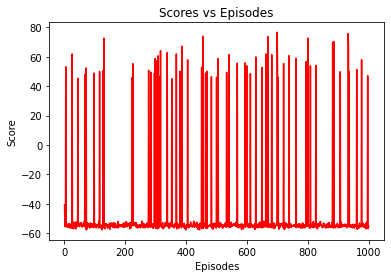

In [16]:
epoch_x = [x for x in range(1, 1001)]

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epoch_x, score_list, color = 'r')
plt.title("Scores vs Episodes")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.show()